In [27]:
import pandapower as pp

import pandas as pd
import numpy as np
from numpy.random import default_rng
import cvxpy as cp
import networkx as nx
import mosek

from solution_files_manager import SolutionFilesManager
from opt_utils import *
from opf_utils import *

In [28]:
import os
folder = os.path.abspath(os.getcwd())

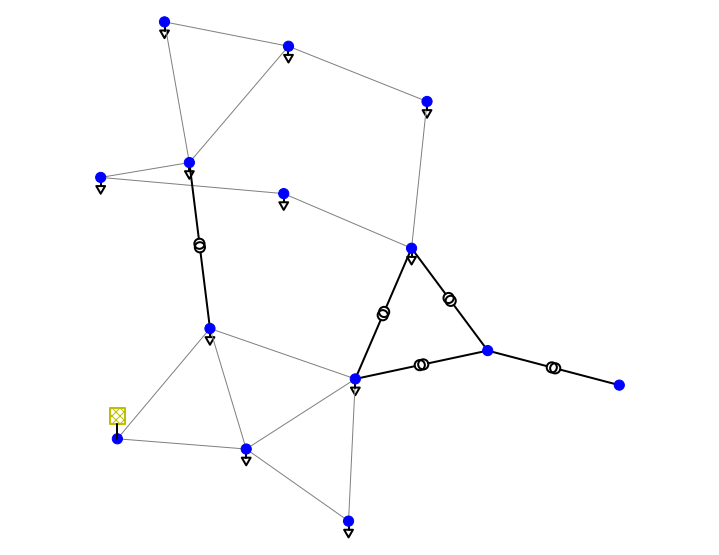

In [29]:
case = "case14"
net, n, gen_df, n_gen, gens, load_df, graph, G_val, B_val, Y_val = load_pp_network(case)

## Variables

In [30]:
# X = VV*
X = cp.Variable((n,n), hermitian=True)
# active power generated
p_g = cp.Variable((n_gen, 1))
# reactive power generated
q_g = cp.Variable((n_gen, 1))

## Parameters

In [31]:
p_d_val = load_df[["p_mw"]].to_numpy() / net.sn_mva
q_d_val = load_df[["q_mvar"]].to_numpy() / net.sn_mva

In [32]:
# loads
p_d = cp.Parameter((n,1), nonneg=True, value=p_d_val)
q_d = cp.Parameter((n,1), value=q_d_val)

# admittance matrices
G = cp.Parameter((n,n), symmetric=True, value=G_val)
B = cp.Parameter((n,n), symmetric=True, value=B_val)
Y = cp.Parameter((n,n), complex=True, value=Y_val)

# squares of voltage bounds
V_min_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["min_vm_pu"].to_numpy()))
V_max_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["max_vm_pu"].to_numpy()))

# bounds for generated power
p_min = cp.Parameter((n_gen,1), value=gen_df[["min_p_mw"]].to_numpy() / net.sn_mva)
p_max = cp.Parameter((n_gen,1), value=gen_df[["max_p_mw"]].to_numpy() / net.sn_mva)
q_min = cp.Parameter((n_gen,1), value=gen_df[["min_q_mvar"]].to_numpy() / net.sn_mva)
q_max = cp.Parameter((n_gen,1), value=gen_df[["max_q_mvar"]].to_numpy() / net.sn_mva)

In [33]:
# vectors of cost coefficients: c_[p or q]_[power]
# costs are only on generators

c_p_2 = cp.Parameter(n_gen, value=gen_df["cp2_eur_per_mw2"].to_numpy() * (net.sn_mva ** 2), nonneg=True)
c_p_1 = cp.Parameter(n_gen, value=gen_df["cp1_eur_per_mw"].to_numpy() * net.sn_mva, nonneg=True)
c_p_0 = cp.Parameter(n_gen, value=gen_df["cp0_eur"].to_numpy(), nonneg=True)

c_q_2 = cp.Parameter(n_gen, value=gen_df["cq2_eur_per_mvar2"].to_numpy() * (net.sn_mva ** 2), nonneg=True)
c_q_1 = cp.Parameter(n_gen, value=gen_df["cq1_eur_per_mvar"].to_numpy() * net.sn_mva, nonneg=True)
c_q_0 = cp.Parameter(n_gen, value=gen_df["cq0_eur"].to_numpy(), nonneg=True)

In [34]:
# SOCP constraint
# constraints = [ cp.quad_over_lin(cp.norm(X[i][j]), cp.real(X[i][i])) <= cp.real(X[j][j]) for i,j in graph.edges]

In [35]:
constraints = [X >> 0]

for i in range(n):
    # make a list of all generators connected to bus i
    gen_list = gen_df.loc[gen_df["bus"] == i].index.to_numpy()
    constraints += [
        cp.sum([p_g[k] for k in gen_list]) - p_d[i] == G[i][i] * X[i][i] +
        cp.sum([G[i][j] * cp.real(X[i][j]) + B[i][j] * cp.imag(X[i][j]) for j in graph.neighbors(i)])
    ]
    constraints += [
        cp.sum([q_g[k] for k in gen_list]) - q_d[i] == -B[i][i] * X[i][i] +
        cp.sum([-B[i][j] * cp.real(X[i][j]) + G[i][j] * cp.imag(X[i][j]) for j in graph.neighbors(i)])
    ]

constraints += [
    cp.real(cp.diag(X)) >= V_min_sq,
    cp.real(cp.diag(X)) <= V_max_sq
]

constraints += [
    p_g >= p_min,
    p_g <= p_max,
    q_g >= q_min,
    q_g <= q_max
]

In [36]:
p_cost = c_p_2 @ cp.square(p_g) + c_p_1 @ p_g + cp.sum(c_p_0)
q_cost = c_q_2 @ cp.square(q_g) + c_q_1 @ q_g + cp.sum(c_q_0)

In [37]:
# power generation cost
prob = cp.Problem(cp.Minimize(p_cost + q_cost), constraints)

# heuristic penalization
# prob = cp.Problem(cp.Minimize(p_cost + q_cost + 0.5 * cp.sum(q_g)), constraints)
# prob = cp.Problem(cp.Minimize(p_cost + q_cost - cp.real(cp.sum(X))), constraints)

In [38]:
# prob.solve(solver=cp.SCS, verbose=True)  # eps=1e-6
# prob.solve(solver=cp.CVXOPT, verbose=True)
prob.solve(solver=cp.MOSEK, mosek_params={mosek.iparam.intpnt_solve_form : mosek.solveform.dual}, verbose=False)

8079.950249969521

In [40]:
# # print original cost (if using penalization)
# print(p_cost.value + q_cost.value)

### Hyperplane rounding

In [41]:
def cost_from_exact_solution(v):
    X_exact = np.outer(v, v.conj())
    p_g, q_g = compute_generation(X_exact, n_gen, p_d_val, q_d_val, G_val, B_val, graph)
    p_cost = np.sum(c_p_2.value @ np.square(p_g) + c_p_1.value @ p_g + np.sum(c_p_0.value))
    q_cost = np.sum(c_q_2.value @ np.square(q_g) + c_q_1.value @ q_g + np.sum(c_q_0.value))
    return p_cost + q_cost

In [42]:
# note that this usually results in an infeasible point
hyperplane_cost, hyperplane_v = complex_hyperplane_rounding(decompose_psd(X.value), cost_from_exact_solution, net.bus["min_vm_pu"].to_numpy(), net.bus["max_vm_pu"].to_numpy())
print(hyperplane_cost)

-15402.542054267062


/home/ivanightingale/Documents/power-system-convex-optimization/opf_utils.py:127: ComplexWarning: Casting complex values to real discards the imaginary part
  p_g[i] = p_d[i][0] + G[i][i] * X[i][i] + np.sum(
/home/ivanightingale/Documents/power-system-convex-optimization/opf_utils.py:129: ComplexWarning: Casting complex values to real discards the imaginary part
  q_g[i] = q_d[i][0] - B[i][i] * X[i][i] + np.sum(


In [43]:
check_power_feasibility(hyperplane_v, p_min.value, p_max.value, q_min.value, q_max.value, gens, n_gen, p_d_val, q_d_val, G_val, B_val, graph)

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
# sfm = SolutionFilesManager(folder, case, "orig")
# a = sfm.load_solution()
# v = a[1]
# X_val = np.outer(v, v.conj())
# X.value = X_val
#
# for c in prob.constraints:
#     print(c.violation())

In [ ]:
# sfm = SolutionFilesManager(folder, case, "sdp")
# sfm.save_solution(prob.value, X, p_g, q_g)